# Semi-supervised anomaly detection - Spectral centroid

This notebook will show how to create an AE model with the [spectral centroid](https://en.wikipedia.org/wiki/Spectral_centroid) of the audio samples. Although most AE models for audios use 2D audio features (spectrogram, mel-spectrogram...), 1D audio features can be used too.

## Libraries

Let's load the libraries for this notebook.
- **Tensorflow dataset** to load the dataset
- **Tensorflow** to create an AE model
- **Pandas** to manipulate results
- **Sklearn** to compute metrics
- **Plotnine** to plot results

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

from tensorflow.keras.layers import (
    InputLayer,
    Dense,
    BatchNormalization,
    Activation,

)
from tensorflow.keras import Sequential

import numpy as np
import pandas as pd

import sklearn
from sklearn.metrics import (
    confusion_matrix, 
    classification_report,
    roc_auc_score
)

import plotnine as p9

import datetime

import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
print(f"Tensorflow datasets: {tfds.__version__}")
print(f"Tensorflow: {tf.__version__}")
print(f"Sklearn: {sklearn.__version__}")
print(f"Numpy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"Plotnine: {p9.__version__}")

Tensorflow datasets: 4.2.0
Tensorflow: 2.4.1
Sklearn: 0.24.2
Numpy: 1.19.5
Pandas: 1.2.4
Plotnine: 0.8.0


Let's set the seed for the Tensorflow dataset.

In [3]:
config = tfds.ReadConfig(try_autocache=True, shuffle_seed=42)

## Dataset

Let's load the dataset and create three sets (train, validation, test). We make the train set (90%) and validation set (10%) from the train data and the test set from the test data. 

In [4]:
import pump
data_dir = "../dataset"

(train, val, test), info = tfds.load(
    "pump",
    split=["train[:90%]", "train[90%:]", "test"],
    data_dir=data_dir,
    with_info=True,
    shuffle_files=True,
    read_config=config,
)

## Feature extraction

Let's extract the audio feature for the AE model.

To get the spectral centroid of the audios, we need to:
- Calculate the magnitude from the STFT of the audio sample with an analysis frame of 64ms and 50% hop size.
- Calculate the spectral centroid:

![spectral centroid](https://wikimedia.org/api/rest_v1/media/math/render/svg/0a62c839a6ceafd854138264d81b2986d8cdaff1)

In [5]:
def spectral_centroid(item):
    audio = tf.cast(item["audio"], dtype = tf.float32)
    audio = audio / 2**15
    audio = tf.signal.stft(audio, frame_length=1024, frame_step=512)
    audio = tf.abs(audio)
    freqs = tf.constant(np.arange(0,513), dtype=audio.dtype)
    item["audio"] = tf.reduce_sum(audio * freqs, axis=1) / tf.reduce_sum(audio, axis=1)
    return item

Let's prepare the sets for training. AE models need that the input and the output be the same.

In [6]:
def prep_train(item):
    return item["audio"], item["audio"]

In [7]:
BATCH_SIZE = 256
SHUFFLE_BUFFER_SIZE = 1024

train = train.map(spectral_centroid)
train2 = train.map(prep_train).batch(BATCH_SIZE)

val = train.map(spectral_centroid)
val2 = train.map(prep_train).batch(BATCH_SIZE)

test = test.map(spectral_centroid)
test2 = test.batch(BATCH_SIZE)

## Training

Let's create an simple AE model. 

![AE model](https://d1jnx9ba8s6j9r.cloudfront.net/blog/wp-content/uploads/2018/10/Autoencoders-528x265.png)

In [8]:
autoencoder = Sequential(
    [
        InputLayer(input_shape=311),
        BatchNormalization(),
        Dense(128),
        BatchNormalization(),
        Activation('elu'),
        Dense(32),
        BatchNormalization(),
        Activation('elu'),
        Dense(8),
        BatchNormalization(),
        Activation('elu'),
        Dense(32),
        BatchNormalization(),
        Activation('elu'),
        Dense(128),
        BatchNormalization(),
        Activation('elu'),
        Dense(311, activation=None),
    ]
)

autoencoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 311)               1244      
_________________________________________________________________
dense (Dense)                (None, 128)               39936     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
activation (Activation)      (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
_________________________________________________________________
activation_1 (Activation)    (None, 32)                0

We can use [rmsprop](https://optimization.cbe.cornell.edu/index.php?title=RMSProp) as the optimizer and the [mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error) as the loss function. 

In [9]:
autoencoder.compile(optimizer='rmsprop', loss='mse')

Let's create a Tensorboard callback to check the results in Tensorboard and a ModelCheckpoint callback to save the best model.

In [10]:
log_dir = os.path.join('..', 'logs', 'semi-centroid', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
tb_callback = tf.keras.callbacks.TensorBoard(
    log_dir, update_freq=1, histogram_freq=1, write_graph=True
)

In [11]:
checkpoint_filepath = os.path.join("tmp", "semi-centroid", "checkpoint")
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

AE models needs that the input and the output be same.

In [12]:
history = autoencoder.fit(
    train2,
    epochs=100,
    shuffle=True,
    validation_data=val2,
    callbacks=[tb_callback, model_checkpoint_callback],
    verbose=1,
)

Epoch 1/100
12/12 [==============================] - 31s 3s/step - loss: 19112.2237 - val_loss: 17213.7148
Epoch 2/100
12/12 [==============================] - 33s 3s/step - loss: 18848.0107 - val_loss: 18157.8730
Epoch 3/100
12/12 [==============================] - 34s 3s/step - loss: 18655.9058 - val_loss: 18657.9023
Epoch 4/100
12/12 [==============================] - 33s 3s/step - loss: 18497.2981 - val_loss: 17852.4668
Epoch 5/100
12/12 [==============================] - 33s 3s/step - loss: 18373.6707 - val_loss: 17061.4805
Epoch 6/100
12/12 [==============================] - 33s 3s/step - loss: 18264.0781 - val_loss: 16257.4756
Epoch 7/100
12/12 [==============================] - 33s 3s/step - loss: 17765.0129 - val_loss: 15978.2549
Epoch 8/100
12/12 [==============================] - 33s 3s/step - loss: 17639.6804 - val_loss: 15037.7598
Epoch 9/100
12/12 [==============================] - 33s 3s/step - loss: 17382.2763 - val_loss: 13816.7480
Epoch 10/100
12/12 [=================

## Testing

In [ ]:
autoencoder.load_weights(checkpoint_filepath)

In [ ]:
VERSION="1"
saved_model_path = autoencoder.save(
    os.path.join("..", "..", "..", "production", "backend", "models", "centroid", VERSION),
    save_format="tf",
)

Let's join train and test set together for faster predictions.

In [ ]:
audios = train.concatenate(test)

In [16]:
pred = autoencoder.predict(audios.map(lambda item: item["audio"]).batch(BATCH_SIZE))

INFO:tensorflow:Assets written to: ..\..\..\production\backend\models\centroid\1\assets


INFO:tensorflow:Assets written to: ..\..\..\production\backend\models\centroid\1\assets


Let's compute the reconstruction error for all audios.

In [17]:
error_lst = []
for item, pred in zip(tfds.as_numpy(audios), pred):
    error = np.mean(np.square(item["audio"] - pred))
    error_lst.append(error)

To check how the model behaves, we can tranform the Tensorflow dataset into a dataframe and add the previous computed reconstruction error to it.

In [18]:
audios_df = tfds.as_dataframe(audios, info)

# Convert byte-type texts to string-type texts
for col in audios_df:
    if isinstance(audios_df[col][0], bytes):
        audios_df[col] = audios_df[col].str.decode("utf8")

dct_columns = {
    "audio/id": "id", 
    "audio/machine": "machine_id", 
    "audio/split": "split",
}

# Convert object-type columns to a more convenient data type
dct_types = {
    "id": "string",
    "machine_id": "category",
    "split": "category",
    "label": "category",
}

audios_df = (
    audios_df
    .rename(columns=dct_columns)
    .astype(dct_types)
)

audios_df["split"] = audios_df["split"].cat.rename_categories({0: "train", 1: "test"})
audios_df["label"] = audios_df["label"].cat.rename_categories({0: "normal", 1: "anomaly"})

audios_df.sample(5)

,audio,id,machine_id,split,label
1939,"[141.96213, 135.21071, 156.37888, 138.22511, 1...",0331,04,train,normal
63,"[147.94125, 149.40681, 138.04012, 139.77148, 1...",0611,06,train,normal
1273,"[205.14688, 208.08266, 206.38641, 210.40247, 2...",0220,04,train,normal
1235,"[129.71925, 137.43721, 127.42038, 124.91373, 1...",0031,02,train,normal
1443,"[136.3867, 139.09085, 142.84888, 154.52092, 15...",0852,00,train,normal


In [19]:
audios_df["error"] = error_lst

In [20]:
audios_df.sample(5)

,audio,id,machine_id,split,label,error
904,"[159.53131, 151.75444, 148.79333, 155.70522, 1...",0340,04,train,normal,1274.666748
2214,"[123.27612, 127.64881, 118.96919, 115.40276, 1...",0187,00,train,normal,3696.071533
1548,"[153.80484, 165.31131, 152.8622, 156.73428, 15...",0038,06,train,normal,2914.486816
934,"[140.08467, 154.24051, 137.64276, 150.83852, 1...",0210,04,train,normal,674.132568
987,"[120.24725, 105.67785, 109.01134, 103.64985, 1...",0888,02,train,normal,214.587067


In [21]:
(
    audios_df
    .query("split == 'train'")
    .groupby("machine_id")
    .agg({"error": ["mean", "std"]})
)

error             
                   mean          std
machine_id                          
00          1445.975659  1972.854052
02          1445.460055  2217.711531
04          1410.948863  1899.313640
06          1413.841140  1941.412422

In [22]:
(
    audios_df
    .query("split == 'test'")
    .groupby(["label", "machine_id"])
    .agg({"error": ["mean", "std"]})
)

error             
                           mean          std
label   machine_id                          
normal  00          1654.178050  2003.839754
        02          1460.456207  1778.772359
        04          1557.179548  1848.720275
        06          1769.624605  1894.737667
anomaly 00          1306.736289  1584.613099
        02          1487.242603  1775.948641
        04          1392.167999  1685.080205
        06          1761.334523  1972.483752

It seems this model can't distinguish anomaly sound from normal sounds very well.

Let's plot the a histogram of the construction error per machine to see more clear.

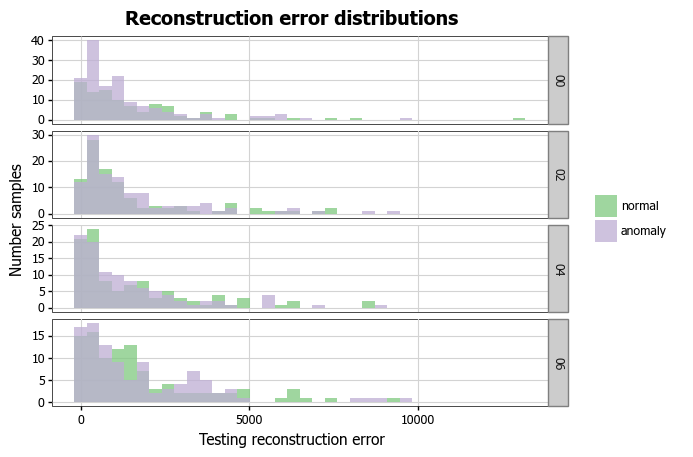

In [23]:
p = (
    p9.ggplot(audios_df.query("split == 'test'"), p9.aes(x="error", fill="label"))
    + p9.geom_histogram(
        p9.aes(y="stat(count)"), position="identity", alpha=0.75
    )
    + p9.scale_x_continuous(name="Testing reconstruction error")
    + p9.scale_y_continuous(name="Number samples")
    + p9.labs(
        title="Reconstruction error distributions",
    )
    + p9.scale_fill_brewer(type="qualitative", palette="Accent") 
    + p9.facet_grid("machine_id ~ .", scales="free")
    + p9.theme_bw()
    + p9.theme(
        panel_border=p9.element_rect(colour="black", fill=None, size=0.5),
        axis_text_x=p9.element_text(colour="black", size=9),
        axis_text_y=p9.element_text(colour="black", size=9),
        legend_key=p9.element_blank(),
        legend_title=p9.element_blank(),
        panel_grid_major=p9.element_line(colour="#d3d3d3"),
        panel_grid_minor=p9.element_blank(),
        panel_background=p9.element_blank(),
        plot_title=p9.element_text(size=14, family="Tahoma", face="bold"),
        text=p9.element_text(family="Tahoma"),
    )
)

print(p)

Histograms show more clear that the model can't differentiate anomaly audios from normal audio very well.

This [AWS](https://aws.amazon.com/es/blogs/machine-learning/performing-anomaly-detection-on-industrial-equipment-using-audio-signals/) post shows how the histogram from a good model should look like.

![Better model](https://d2908q01vomqb2.cloudfront.net/f1f836cb4ea6efb2a0b1b99f41ad8b103eff4b59/2020/12/22/ML-1479-4.jpg)

## Metrics

Let's see how bad our model is. To distinguish anomaly audios from normal audios, we set the threshold one standard deviation above the mean of the train set. 

In [24]:
avg = (
    audios_df
    .query("split == 'train'")
    ["error"]
    .mean()
)

std = (
    audios_df
    .query("split == 'train'")
    ["error"]
    .std()
)

threshold = avg + std

In [25]:
print(threshold)

3450.7522445185577


Let's create a new column with the predicted label based on the threshold.

In [26]:
audios_df["label_pred"] = audios_df["error"] > threshold

audios_df = audios_df.astype({"label_pred": "int"})
audios_df.head()

,audio,id,machine_id,split,label,error,label_pred
0,"[167.79619, 148.82285, 155.80418, 157.08049, 1...",0811,02,train,normal,560.878235,0
1,"[123.45275, 121.31313, 137.93771, 127.775246, ...",0144,00,train,normal,2783.420898,0
2,"[128.69463, 133.42935, 147.16164, 122.406494, ...",0773,06,train,normal,5021.331055,1
3,"[122.336296, 111.70874, 117.87651, 117.789314,...",0425,02,train,normal,736.690002,0
4,"[126.35325, 128.95583, 137.11765, 142.96132, 1...",0191,04,train,normal,4387.797363,1


Let's show the precision, recall, f1-score and roc-auc score for the four machines.

In [27]:
audios_df["label"] = audios_df["label"].cat.rename_categories({"normal": 0, "anomaly": 1})

### Machine_id=00

In [28]:
machine_id = "00"
temp = (
    audios_df
    .query("machine_id == @machine_id and split == 'test'")
)  
print(classification_report(temp["label"], temp["label_pred"]))

              precision    recall  f1-score   support

           0       0.40      0.87      0.55       100
           1       0.50      0.09      0.15       143

    accuracy                           0.41       243
   macro avg       0.45      0.48      0.35       243
weighted avg       0.46      0.41      0.32       243



In [29]:
print(confusion_matrix(temp["label"], temp["label_pred"]))

[[ 87  13]
 [130  13]]


In [30]:
score = roc_auc_score(temp["label"], temp["label_pred"])
print(f"ROC-AUC score: {score:.4f}")

ROC-AUC score: 0.4805


This model is so bad distinguishing sounds for this machine that tossing a coin can predict better. 

### Machine_id=02

In [31]:
machine_id = "02"
temp = (
    audios_df
    .query("machine_id == @machine_id and split == 'test'")
)  
print(classification_report(temp["label"], temp["label_pred"]))

              precision    recall  f1-score   support

           0       0.47      0.87      0.61       100
           1       0.50      0.12      0.19       111

    accuracy                           0.47       211
   macro avg       0.49      0.49      0.40       211
weighted avg       0.49      0.47      0.39       211



In [32]:
print(confusion_matrix(temp["label"], temp["label_pred"]))

[[87 13]
 [98 13]]


In [33]:
score = roc_auc_score(temp["label"], temp["label_pred"])
print(f"ROC-AUC score: {score:.4f}")

ROC-AUC score: 0.4936


This model is so bad distinguishing sounds for this machine that tossing a coin can predict better. 

### Machine_id=04

In [34]:
machine_id = "04"
temp = (
    audios_df
    .query("machine_id == @machine_id and split == 'test'")
)  
print(classification_report(temp["label"], temp["label_pred"]))

              precision    recall  f1-score   support

           0       0.49      0.86      0.63       100
           1       0.44      0.11      0.18       100

    accuracy                           0.48       200
   macro avg       0.47      0.48      0.40       200
weighted avg       0.47      0.48      0.40       200



In [35]:
print(confusion_matrix(temp["label"], temp["label_pred"]))

[[86 14]
 [89 11]]


In [36]:
score = roc_auc_score(temp["label"], temp["label_pred"])
print(f"ROC-AUC score: {score:.4f}")

ROC-AUC score: 0.4850


This model is so bad distinguishing sounds for this machine that tossing a coin can predict better. 

### Machine_id=06

In [37]:
machine_id = "06"
temp = (
    audios_df
    .query("machine_id == @machine_id and split == 'test'")
)  
print(classification_report(temp["label"], temp["label_pred"]))

              precision    recall  f1-score   support

           0       0.49      0.83      0.62       100
           1       0.48      0.16      0.24       102

    accuracy                           0.49       202
   macro avg       0.49      0.49      0.43       202
weighted avg       0.49      0.49      0.43       202



In [38]:
print(confusion_matrix(temp["label"], temp["label_pred"]))

[[83 17]
 [86 16]]


In [39]:
score = roc_auc_score(temp["label"], temp["label_pred"])
print(f"ROC-AUC score: {score:.4f}")

ROC-AUC score: 0.4934


This model is so bad distinguishing sounds for this machine that tossing a coin can predict better. 

## Conclusions

This model doesn't help to distinguish anomalous sounds from normal audios. 